# Lab 2: Edge detection
-----
-----
## Introduction
In this lab, we will shift our attention to edge detection and how it can be used to locate flame fronts in OH-PLIF images. We will implement the state-of-the-art Canny edge detection algorithm step by step, then use it on a series of OH-PLIF images.
\
\
The detailed steps of the algorithm are available in the background section of Chaib et al. 2023. There are four steps overall with input parameters required at steps 1 and 4 : 
1) Gaussian filtering (input : standard deviation $\sigma$).\
2) Gradient computation.\
3) Non-maxima suppression.\
4) Hysteresis thresholding (input : thresholds $t_{low}$ and $t_{high}$).
\
\
In this lab, we will combine steps 1 and 2 using the derivative theorem of convolution for faster computation time: 
\begin{align}
\nabla P = \nabla (G_{\sigma} \circledast I) =  (\nabla G_{\sigma}) \circledast I
\end{align}
Instead of filtering the image with a Gaussian kernel then computing the gradient, convolving it directly with a derivative of Gaussian (DoG) kernel produces the same result but faster.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy as sci
import ipywidgets

We will first start by loading one of the images.

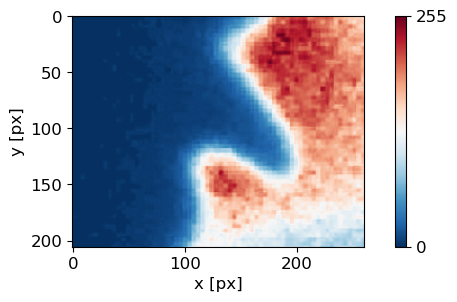

In [8]:
img = cv2.imread("data/demo3.png",cv2.IMREAD_GRAYSCALE)
img = 255*(img/np.max(img))
img = img.astype(np.uint8)
plt.figure(figsize=(10,3))
plt.imshow(img, cmap='RdBu_r', vmin=0, vmax=255)
plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.show()

Before edge detection, filtering the image is necessary. We will be using an edge-preserving filter on the image prior to the edge detection process.

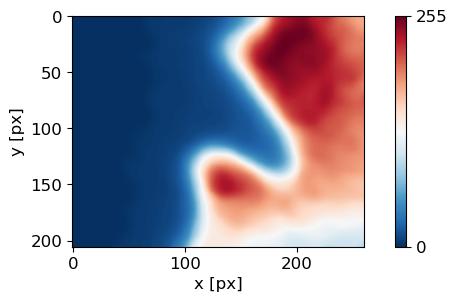

In [9]:
from skimage.restoration import denoise_tv_bregman as edge_preserving_filter

img = cv2.medianBlur(img,13)
img = edge_preserving_filter(img,weight = 1, max_num_iter=100)
img = 255*(img/np.max(img))
img = img.astype(np.uint8)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='RdBu_r', vmin=0, vmax=255)
plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.show()

----
## 1+2) Gaussian filtering + Gradient computation
We will first start by creating a DoG kernel. In general, two parameters are required: the standard devation $\sigma$ of the kernel and its width. Usually, the width is set a to product of the $\sigma$ (typically $4\sigma$). The kernel should sum up to one to ensure the mean image stays the same.
\
\
Gradient computation is done by convolving the DoG kernel with the image across both the radial and axial directions, the combining both components of the gradient to obtain the magnitude. The two components can then be used to extract the direction of the gradient at every pixel.

In [13]:
def filt_grad(sigma = 2, flag = 0):
    # Input parameters
    width = int(np.ceil(4*sigma))

    # Creating Gaussian kernel
    H = np.zeros(width)
    for i in range(0,int(width)):
        x = i - ((width-1)/2)
        H[i] = np.exp(-(x**2)/(2*sigma**2))

    H = H*(1/(np.sqrt(2*np.pi)*sigma))
    H = H/np.sum(H) # ensuring the kernel sums up to zero

    # Creating 1D DoG kernel
    DoG = np.gradient(H)
    DoG[np.sign(DoG) == -1] = DoG[np.sign(DoG) == -1]/-np.sum(DoG[np.sign(DoG) == -1]) # ensuring the kernel sums up to zero
    DoG[np.sign(DoG) == +1] = DoG[np.sign(DoG) == +1]/np.sum(DoG[np.sign(DoG) == +1]) # ensuring the kernel sums up to zero

    # Computing gradient via convolution
    # Reshaping the 1D filter into a 2D matrix with a single column
    DoGx = np.reshape(DoG, (1, -1))
    DoGy = np.reshape(DoG, (-1, 1))
    # Performing 1D convolution along rows
    dx = sci.signal.convolve2d(img, DoGx, mode='same', boundary= "symm") # x component
    dy = -sci.signal.convolve2d(img, DoGy, mode='same', boundary= "symm") # y component
    D = np.sqrt(dx**2+dy**2)  # 2D gradient norm
    D = D/np.max(D) # Normalized 2D gradient
    
    # Angle with respect to the axis of the burner in degrees
    theta = np.arctan(dy,dx)
    theta = np.abs(theta*180/np.pi)
    
    if flag:
        # Plotting
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))
        plt.subplot(131)
        plt.plot(np.linspace(-len(DoG)/2,len(DoG)/2, num = len(DoG)),H, label = "Gaussian")
        plt.plot(np.linspace(-len(DoG)/2,len(DoG)/2, num = len(DoG)),DoG, label = "DoG")
        plt.xlabel("x [px]")
        plt.ylabel("Magnitude [-]")
        plt.xlim(-25,25)
        plt.ylim(-.4,.4)
        plt.grid()
        plt.legend()
        plt.title("1D kernels")

        plt.subplot(132)
        plt.imshow(D,cmap = "RdBu_r",vmin = 0, vmax = 1)
        plt.xlabel("x [px]")
        plt.ylabel("y [px]")
        plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
        plt.title("2D Gradient")

        plt.subplot(133)
        plt.imshow(theta,cmap = "RdBu_r",vmin = 0, vmax = 180)
        plt.xlabel("x [px]")
        plt.ylabel("y [px]")
        plt.rcParams.update({'font.size': 12})
        plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 180])
        plt.title("Gradient angle [deg]")
        plt.show()
    else:
        return D, theta

ipywidgets.interact(filt_grad, sigma = (2,11,1), flag = ipywidgets.fixed(1))


interactive(children=(IntSlider(value=2, description='sigma', max=11, min=2), Output()), _dom_classes=('widget…

<function __main__.filt_grad(sigma=2, flag=0)>

As expected, higher values of $\sigma$ result in better noise reduction as the gradient is computed over a wider range of pixels. However, Gaussian filtering is not edge-preserving. Lower values of sigma $\sigma \sim 2-3$ are therefore advised while edge-preserving filters can be applied to the image before edge detection to eliminate some of the noise in the image.

----
## 3) Non-maxima suppression
In this stage, we will thin the gradient image by discarding non-local maxima. This is done by placing a $3\times3$ px$^2$ kernel at every pixel of the image, and only keeping local maxima in the direction of the gradient given by $\theta$.

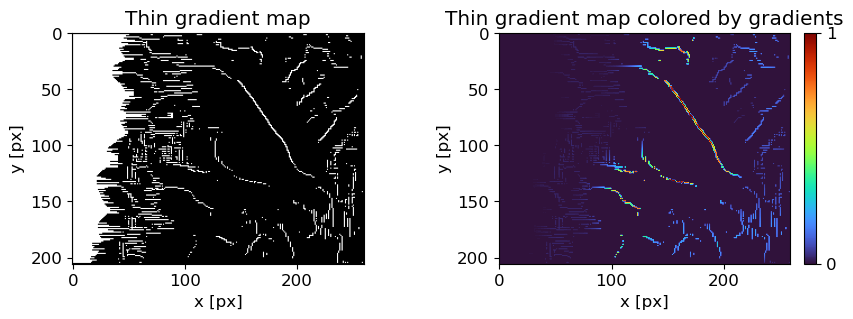

In [11]:
D, theta =  filt_grad(sigma = 10, flag = 0)

# Defining max range
y_max, x_max = D.shape

# Defining final thin image
nms = np.ones(D.shape)
nms[0:,0] = 0
nms[0:,-1] = 0
nms[0,0:] = 0
nms[-1,0:] = 0

mask = np.zeros((3,3))

for j in range(1,y_max-1):
    for i in range(1,x_max-1):
        mask = D[j-1:j+2,i-1:i+2]
        if 0<=theta[j,i]<22.5 or 157.5<=theta[j,i]<=180:
            if mask[0,1]>D[j,i] or mask[2,1]>D[j,i]:
                nms[j,i] = 0
        elif 22.5<=theta[j,i]<67.5:
            if mask[0,2]>D[j,i] or mask[2,0]>D[j,i]:
                nms[j,i] = 0
        elif 67.5<=theta[j,i]<112.5:
            if mask[1,0]>D[j,i] or mask[1,2]>D[j,i]:
                nms[j,i] = 0
        elif 112.5<=theta[j,i]<157.5:
                if mask[0,0]>D[j,i] or mask[2,2]>D[j,i]:
                    nms[j,i] = 0

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 3))
plt.subplot(121)
plt.imshow(nms,cmap = "gray",vmin = 0, vmax = 1)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.title("Thin gradient map")

plt.subplot(122)
plt.imshow(D*nms,cmap = "turbo",vmin = 0, vmax = 1)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
plt.title("Thin gradient map colored by gradients")
plt.show()

----
## 4) Hysteresis thresholding
In the final stage of the algorithm, we will be using both the lower and higher threshold to keep the relevant flame edges. There is, in principle, no easy way of predicting what combination of $t_{low}$ and $t_{high}$ will yield the "best" result so it will take some trial and error.

In [12]:
def hysteresis_thresholding(t_high = 0, t_low = 0):
    if t_low > t_high:
        t_low = t_high
        
    F = nms*(D>=t_high)
    coords = np.where((nms-F)>0)

    for k in range(0,int(np.sum(nms-F))):
        j = coords[0][k]
        i = coords[1][k]
        nms2 = F[j-1:j+2,i-1:i+2]
        nms2[1,1] = 0
        if D[j,i]>= t_low and np.sum(nms2)>0:
            F[j,i] = 1
            
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 3))
    plt.subplot(122)
    plt.imshow(F,cmap = "gray",vmin = 0, vmax = 1)
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Final flame edge")

    plt.subplot(121)
    plt.imshow(D*F,cmap = "turbo",vmin = 0, vmax = 1)
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.title("Thin gradient map colored by gradients")
    plt.show()
            
ipywidgets.interact(hysteresis_thresholding, t_high = (0,1,.05), t_low = (0, 1, .05))

interactive(children=(FloatSlider(value=0.0, description='t_high', max=1.0, step=0.05), FloatSlider(value=0.0,…

<function __main__.hysteresis_thresholding(t_high=0, t_low=0)>